# MA Strategy with Volatility Filter

In [2]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics, file_exports

In [4]:
def ma_volatility_filter(inv_amt, prices_df, short_ma, long_ma, 
                vol_threshold,
                transaction_costs=0.001,  # as a percent
                slippage=0.0005,  # as a percent
                  # Changed parameter name
                ):
    df = prices_df.copy()
    df = df.drop(columns=['Dividends', "Capital Gains", "Stock Splits"], errors="ignore") 

    df["MA_short"] = df["Close"].rolling(window=short_ma).mean()
    df["MA_long"] = df["Close"].rolling(window=long_ma).mean()

    # find ATR
    df['ATR'] = (df['High'] - df['Low']).rolling(window=14).mean() # 14 is the "sweet spot", according to its creator J. Welles Wilder Jr.
    df['ATR_pct'] = df['ATR'] / df['Close']

    # Calculate threshold from data (renamed variable)
    atr_cutoff = df['ATR_pct'].quantile(vol_threshold)
    df['high_volatility'] = df['ATR_pct'] > atr_cutoff

    # signal for trading
    df["signal"] = 0
    df.loc[
        (df["MA_short"] > df["MA_long"]) & 
        (~df['high_volatility']) &  # Use ~ instead of == False
        (df['ATR_pct'].notna()),  # Ensure ATR is valid
        "signal"
    ] = 1
    
    # cost calculations
    total_cost = transaction_costs + slippage
    df["position"] = df["signal"].diff()
    df["trade_cost"] = 0.0
    df.loc[df['position'] != 0, 'trade_cost'] = total_cost

    # calculate returns
    df['market_ret'] = df['Close'].pct_change()
    df['strategy_ret'] = df['market_ret'] * df['signal'].shift(1)
    df['strategy_ret_net'] = df['strategy_ret'] - df['trade_cost']
    
    # Market portfolio - buy at beginning, hold for the whole time
    df['market_ret_net'] = df['market_ret'].copy()
    df.loc[df.index[0], 'market_ret_net'] = df.loc[df.index[0], 'market_ret'] - total_cost

    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['market_ret_net']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_ret_net']).cumprod()
    
    # Portfolio value
    df['portfolio_value'] = inv_amt * df['cumulative_strategy']
    df['market_portfolio_value'] = inv_amt * df['cumulative_market']  # Add this for consistency metrics

    df = df.set_index("Date", inplace=False, drop=True, append=False)
   
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()

    return df

In [5]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 20
long_ma = 50
threshold = 0.70
result = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, threshold, transaction_costs=0.001, slippage=0.0005)

In [12]:
result.tail()

,Open,High,Low,Close,Volume,MA_short,MA_long,ATR,ATR_pct,high_volatility,...,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value,market_portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,374.407182,378.114169,371.691250,377.771118,78740100,395.322708,381.919368,5.426407,0.014364,True,...,0.0,0.0,0.003138,0.0,0.0,0.003138,2.214503,1.495374,14953.738973,22145.026369
2022-09-02,381.449562,382.669345,371.967630,373.787781,99632100,394.311145,382.189626,5.870893,0.015706,True,...,0.0,0.0,-0.010544,-0.0,-0.0,-0.010544,2.191152,1.495374,14953.738973,21911.522251
2022-09-06,374.635914,375.579332,370.147495,372.377411,76637400,393.251935,382.202587,5.928749,0.015921,True,...,0.0,0.0,-0.003773,-0.0,-0.0,-0.003773,2.182885,1.495374,14953.738973,21828.846058
2022-09-07,372.062841,379.838970,371.843679,379.067078,70964200,392.605350,382.377738,6.162223,0.016256,True,...,0.0,0.0,0.017965,0.0,0.0,0.017965,2.222100,1.495374,14953.738973,22220.995800
2022-09-08,376.789585,382.002231,375.579312,381.544830,80821700,391.670975,382.753773,6.409311,0.016798,True,...,0.0,0.0,0.006536,0.0,0.0,0.006536,2.236624,1.495374,14953.738973,22366.242209


In [6]:
# export as csv in the data file
csv_name = "ma_volatility_filter.csv"
output_folder = "../data/strategy_results/"

from file_exports import export_file
export_file(csv_name, output_folder, result)

Exported data as file ../data/strategy_results/ma_volatility_filter.csv successfully.


In [13]:
# prelim test on final strategy portfolio value given varying threshold levels
thresholds = [0.5, 0.6, .7, .75, .8, .85, .9, .95]
for t in thresholds:
    res = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, t, transaction_costs=0.001, slippage=0.0005)
    print(f"Threshold = {t}, final value = {res['portfolio_value'].iloc[-1]}")

Threshold = 0.5, final value = 12185.710852628094
Threshold = 0.6, final value = 11811.280248813342
Threshold = 0.7, final value = 14953.73897266936
Threshold = 0.75, final value = 13656.677587307515
Threshold = 0.8, final value = 11820.370100883752
Threshold = 0.85, final value = 13109.178755583613
Threshold = 0.9, final value = 14583.472532704995
Threshold = 0.95, final value = 16812.236910834625


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
Let's examine the returns and P&L of the strategy and market portfolios, considering transaction cost and slippage amounts as defined above.

Final portfolio value: 14953.73897266936 on 2022-09-08 00:00:00
Strategy returned 49.53738972669359% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66242209135079 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy returned 5.3772% per year
Buy & Hold the market returned 11.0467% per year


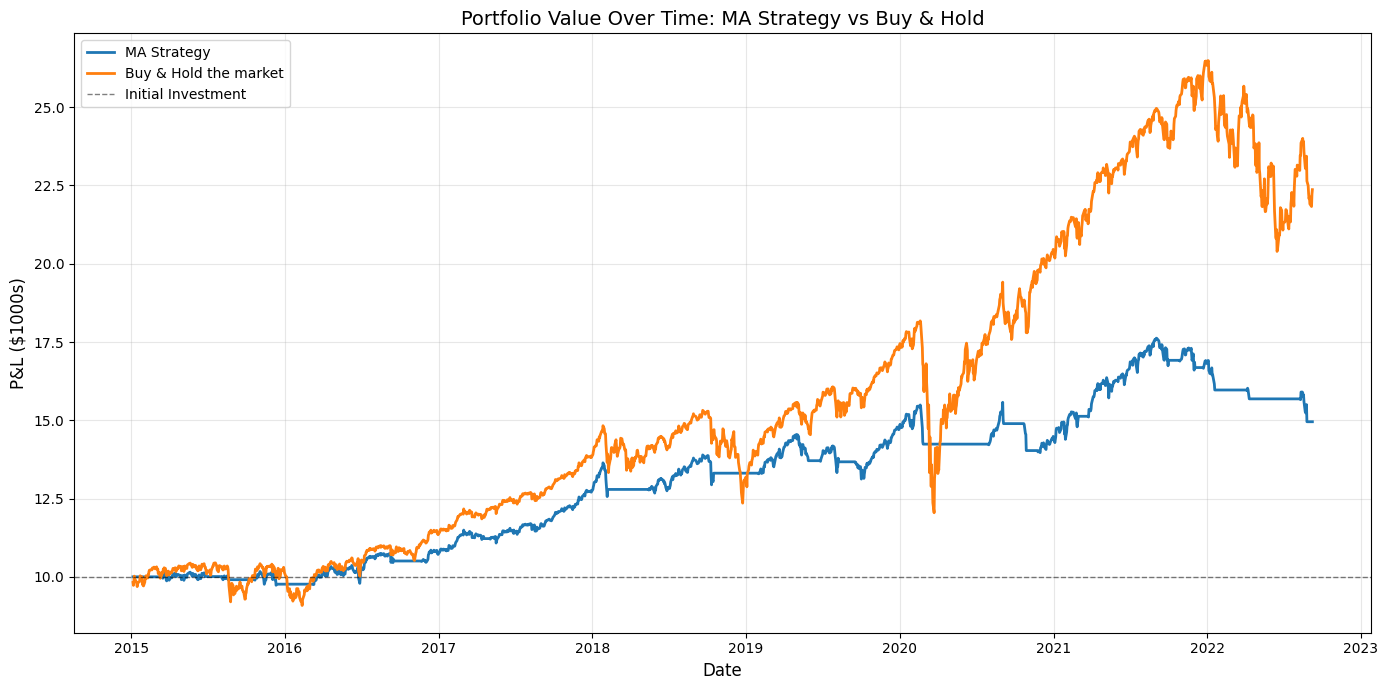

In [14]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy vs Buy & Hold'
strategy_name = "MA Strategy"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [15]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.5019786055841606
Information Ratio: 11.39339347573484
Sortino Ratio: 6.269773501511508 

WITH transaction costs...
Sharpe Ratio: 0.3829775083360474
Information Ratios: 11.363983713201758
Sortino Ratio: 4.784950971127576


In [16]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -15.15%
Average Drawdown: -3.52%
Max Drawdown Duration: 255.00 days
Average Drawdown Duration: 18.53 days
Volatility: 8.80%


### 4. Trade Statistics

In [17]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {trade_stats['num_trades']}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 50
Average Holding Periods: 66.36
Win Rate: 0.6
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 3.26682798970142


### 5. Strategy Beta to Benchmark

In [18]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.22957304526860137
Alpha: 0.012948561912565847
Calmar Ratio: 0.35


### 5. Consistency of Returns

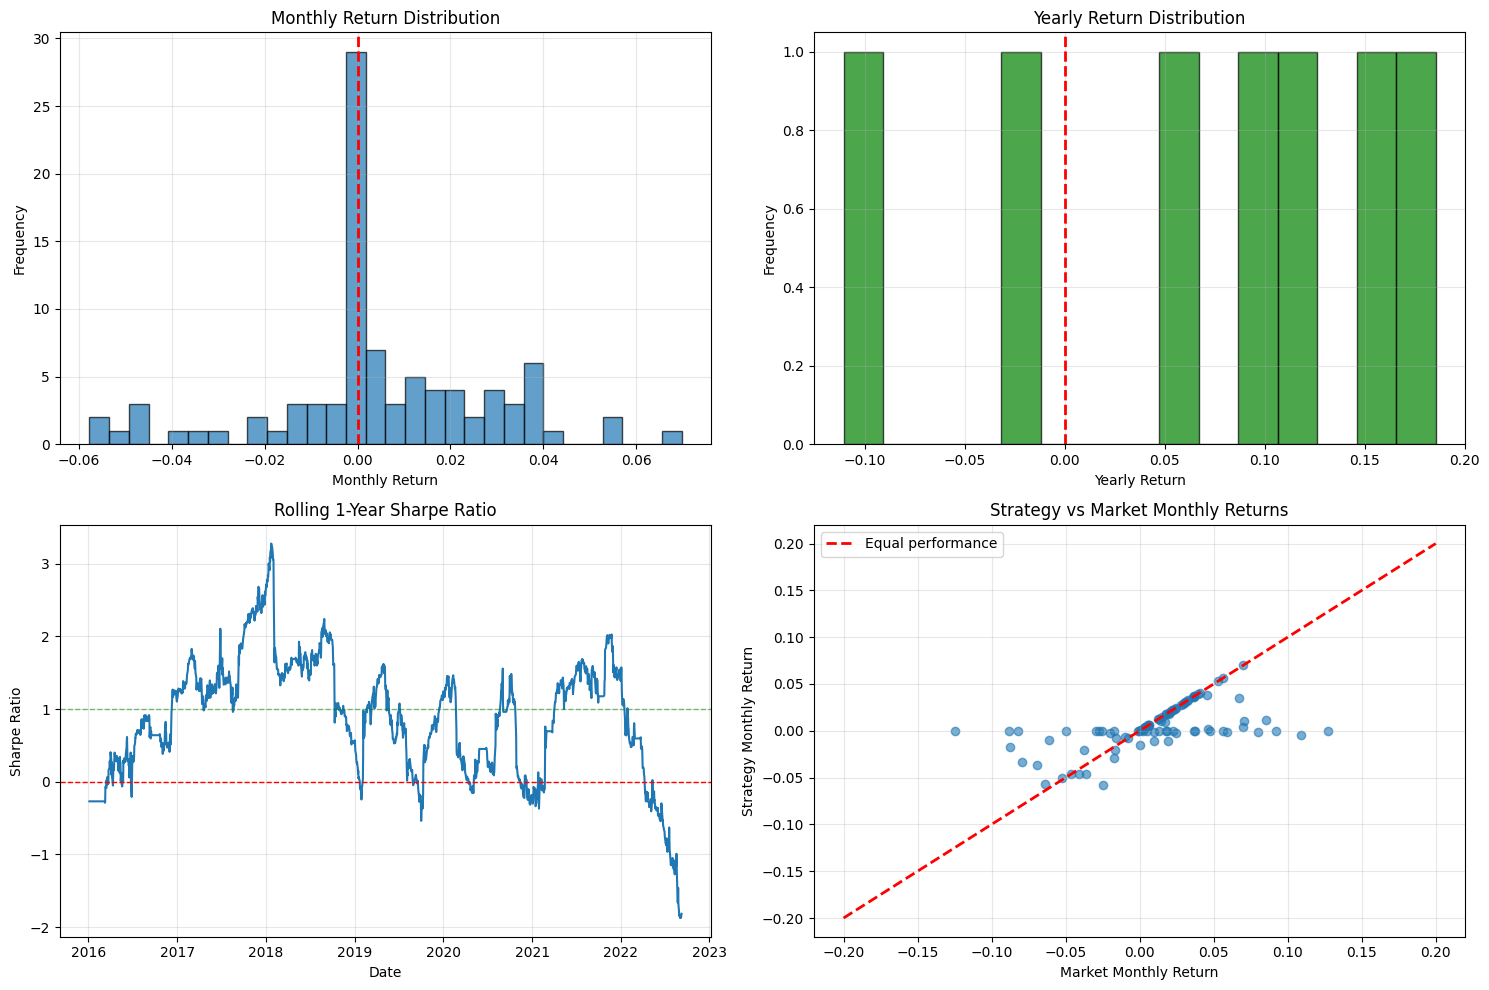

Percentage of Positive Months: 48.39%
Average Monthly Return: 0.47%
Median Monthly Return: 0.00%
Standard Deviation of Monthly Returns: 2.38%
Percentage of Positive Years: 62.50%
Average Yearly Return: 6.73%
Median Yearly Return: 9.71%


In [19]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

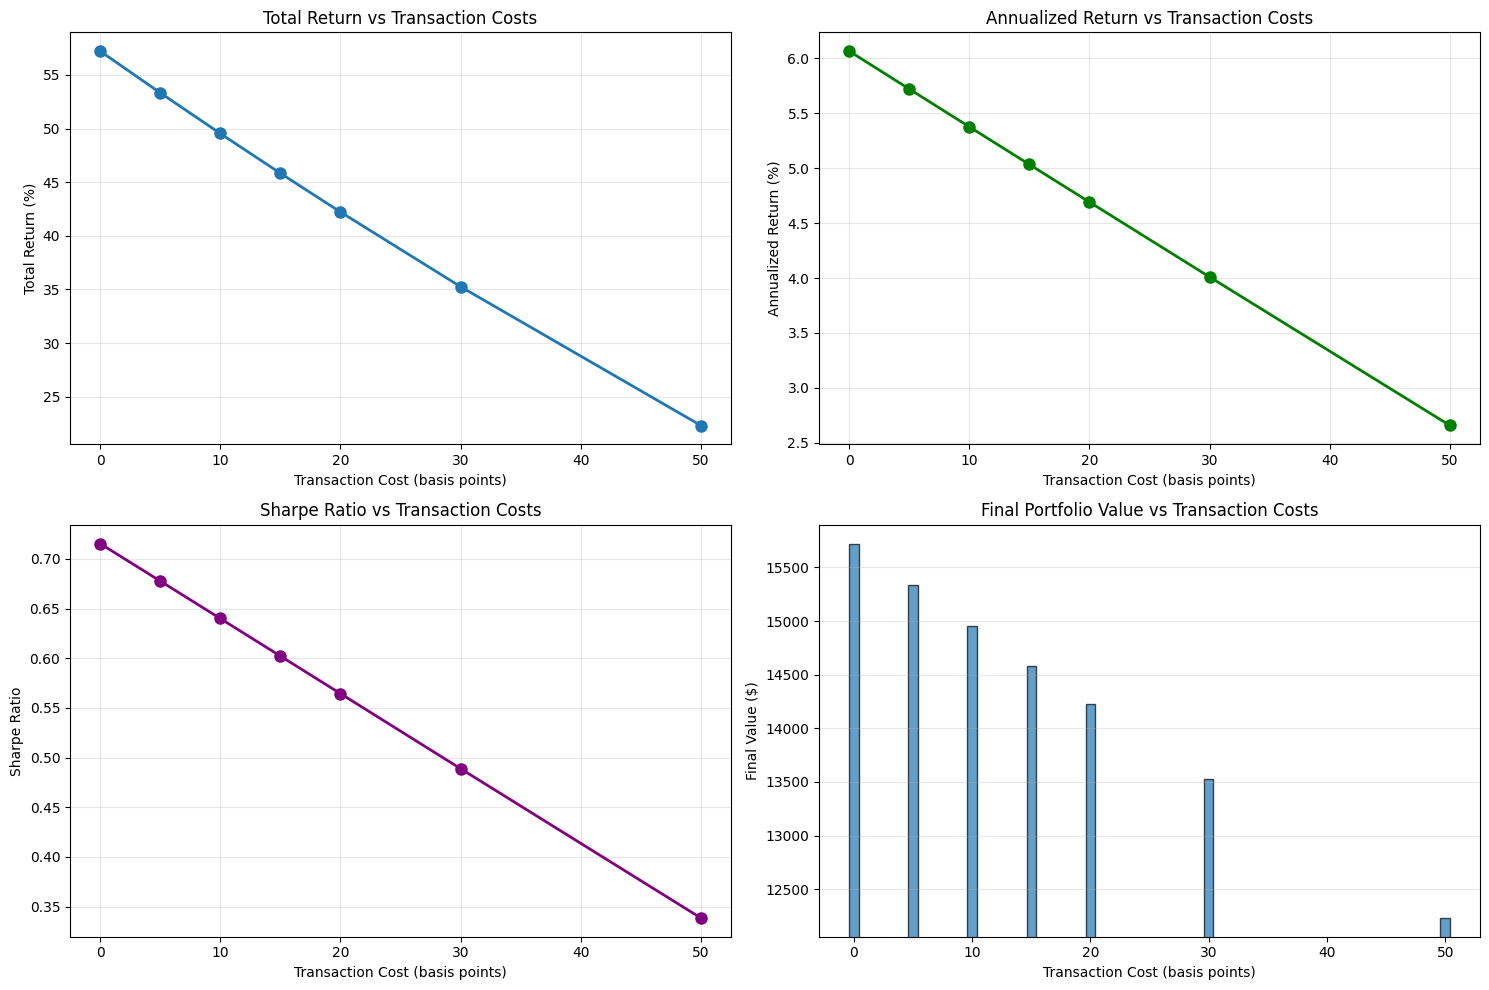

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0      0.00      0.572213           0.060668      0.715482 15722.133275
      5.0      0.05      0.533322           0.057215      0.677808 15333.219785
     10.0      0.10      0.495374           0.053772      0.640068 14953.738973
     15.0      0.15      0.458347           0.050339      0.602286 14583.466618
     20.0      0.20      0.422218           0.046915      0.564485 14222.183721
     30.0      0.30      0.352574           0.040095      0.488922 13525.735695
     50.0      0.50      0.223163           0.026568      0.338584 12231.629403


Strategy remains profitable at all tested cost levels


In [28]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")

def ma_volatility_filter_helper(investment_amount, test_data, short_ma, long_ma, transaction_costs=0.001, slippage=0.0005):
    res = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, threshold, transaction_costs, slippage)
    return res
df = sensitivity(ma_volatility_filter_helper, investment_amount, prices_data, short_ma, long_ma)